In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import matplotlib
#matplotlib.use('Agg')


### Aggregate data across wildcards/folders

In [3]:
# Data to aggregate: <path>/{participation}/{year}/{zone}/{palette}/summary.csv
# Fix {participation} and {palette}
desired_size = '10'
desired_palette = 'p1'

In [4]:
def carbon_drop(scenario):
    base_path = f'../results/paper{scenario}/csvs'
    aggregated_df = pd.DataFrame()

    # Loop through the directory structure
    for root, dirs, files in os.walk(base_path):
        components = root.split(os.sep)
        # print(components)  # for debugging

        # Pickup desired participation and palette
        if len(components) == 8 and components[4] == desired_size and components[7] == desired_palette:
            year, zone = components[5], components[6]

            if 'summary.csv' in files:
                file_path = os.path.join(root, 'summary.csv')
                df = pd.read_csv(file_path, index_col=0)

                emissions_zone_data = df.loc['emissions_zone']
                emissions_zone_data.name = (zone, year)

                if aggregated_df.empty:
                    aggregated_df = pd.DataFrame(columns=emissions_zone_data.index, dtype=float)

                aggregated_df = pd.concat([aggregated_df, emissions_zone_data.to_frame().T], ignore_index=False)

    # Pick necessary scenarios and rename
    aggregated_df.index.names = ['system']
    selected = [col for col in ['ref','cfe100', 'res100'] if col in aggregated_df.columns]
    aggregated_df = aggregated_df[selected]
    aggregated_df[f'diff{scenario}'] = aggregated_df['ref'] - aggregated_df['cfe100']
    aggregated_df.rename(columns={'cfe100': f'cfe100{scenario}'}, inplace=True)

    return aggregated_df


### Isolating profile and volume effects on carbon emissions in local zone

In [5]:
carbon_drop(scenario='')

,ref,cfe100,res100,diff
system,,,,
"(IE, 2025)",4.168777,3.542470,3.689036,0.626307
"(DK, 2025)",5.389010,5.278307,5.295009,0.110703
"(DE, 2025)",118.810889,103.000312,107.080605,15.810577
"(PL, 2025)",83.804790,78.226967,79.258311,5.577824
"(IE, 2030)",2.478082,2.114343,2.279577,0.363740
"(DK, 2030)",0.921909,0.914581,0.916650,0.007328
"(DE, 2030)",50.380531,43.339646,47.396700,7.040885
"(PL, 2030)",15.583535,11.752734,13.355023,3.830801


In [6]:
carbon_drop(scenario='-noexcess')

,ref,cfe100-noexcess,diff-noexcess
system,,,
"(IE, 2025)",4.177328,3.693141,0.484187
"(DK, 2025)",5.389010,5.299968,0.089042
"(DE, 2025)",118.827112,106.186434,12.640678
"(PL, 2025)",83.793742,78.802011,4.991731
"(IE, 2030)",2.492387,2.211865,0.280522
"(DK, 2030)",0.921567,0.914430,0.007137
"(DE, 2030)",50.382612,44.903481,5.479131
"(PL, 2030)",15.608990,13.274702,2.334288


In [7]:
df1 = carbon_drop(scenario='')
df2 = carbon_drop(scenario='-noexcess')
data = df1.copy()

for col in df2.columns:
    if col not in df1.columns:
        data[col] = df2[col]

In [8]:
data

,ref,cfe100,res100,diff,cfe100-noexcess,diff-noexcess
system,,,,,,
"(IE, 2025)",4.168777,3.542470,3.689036,0.626307,3.693141,0.484187
"(DK, 2025)",5.389010,5.278307,5.295009,0.110703,5.299968,0.089042
"(DE, 2025)",118.810889,103.000312,107.080605,15.810577,106.186434,12.640678
"(PL, 2025)",83.804790,78.226967,79.258311,5.577824,78.802011,4.991731
"(IE, 2030)",2.478082,2.114343,2.279577,0.363740,2.211865,0.280522
"(DK, 2030)",0.921909,0.914581,0.916650,0.007328,0.914430,0.007137
"(DE, 2030)",50.380531,43.339646,47.396700,7.040885,44.903481,5.479131
"(PL, 2030)",15.583535,11.752734,13.355023,3.830801,13.274702,2.334288


In [9]:
rename_scen = {
    'ref': 'no procurement',
    'res100': '100% annual matching',
    'cfe100':'100% 24/7 CFE',
    'diff': 'Emissions reduction total',
    'cfe100-noexcess': '100% 24/7 CFE w/o excess',
    'diff-noexcess': 'Profile effect'
        }

data.rename(columns=rename_scen, inplace=True)

In [10]:
data

,no procurement,100% 24/7 CFE,100% annual matching,Emissions reduction total,100% 24/7 CFE w/o excess,Profile effect
system,,,,,,
"(IE, 2025)",4.168777,3.542470,3.689036,0.626307,3.693141,0.484187
"(DK, 2025)",5.389010,5.278307,5.295009,0.110703,5.299968,0.089042
"(DE, 2025)",118.810889,103.000312,107.080605,15.810577,106.186434,12.640678
"(PL, 2025)",83.804790,78.226967,79.258311,5.577824,78.802011,4.991731
"(IE, 2030)",2.478082,2.114343,2.279577,0.363740,2.211865,0.280522
"(DK, 2030)",0.921909,0.914581,0.916650,0.007328,0.914430,0.007137
"(DE, 2030)",50.380531,43.339646,47.396700,7.040885,44.903481,5.479131
"(PL, 2030)",15.583535,11.752734,13.355023,3.830801,13.274702,2.334288


In [11]:
data['Volume effect'] = data['Emissions reduction total'] - data['Profile effect']

In [12]:
data

,no procurement,100% 24/7 CFE,100% annual matching,Emissions reduction total,100% 24/7 CFE w/o excess,Profile effect,Volume effect
system,,,,,,,
"(IE, 2025)",4.168777,3.542470,3.689036,0.626307,3.693141,0.484187,0.142120
"(DK, 2025)",5.389010,5.278307,5.295009,0.110703,5.299968,0.089042,0.021661
"(DE, 2025)",118.810889,103.000312,107.080605,15.810577,106.186434,12.640678,3.169899
"(PL, 2025)",83.804790,78.226967,79.258311,5.577824,78.802011,4.991731,0.586093
"(IE, 2030)",2.478082,2.114343,2.279577,0.363740,2.211865,0.280522,0.083218
"(DK, 2030)",0.921909,0.914581,0.916650,0.007328,0.914430,0.007137,0.000191
"(DE, 2030)",50.380531,43.339646,47.396700,7.040885,44.903481,5.479131,1.561754
"(PL, 2030)",15.583535,11.752734,13.355023,3.830801,13.274702,2.334288,1.496514


In [13]:
fractions = pd.DataFrame()
fractions['Profile effect share'] = (data['Profile effect'] / data['Emissions reduction total']) * 100
fractions['Volume effect share'] = (data['Volume effect'] / data['Emissions reduction total']) * 100
fractions

,Profile effect share,Volume effect share
system,,
"(IE, 2025)",77.308203,22.691797
"(DK, 2025)",80.433387,19.566613
"(DE, 2025)",79.950769,20.049231
"(PL, 2025)",89.492447,10.507553
"(IE, 2030)",77.121691,22.878309
"(DK, 2030)",97.396118,2.603882
"(DE, 2030)",77.818789,22.181211
"(PL, 2030)",60.934708,39.065292


In [14]:
abs = pd.DataFrame()
abs['Profile effect'] = data['Profile effect']
abs['Volume effect'] = data['Volume effect']
abs

,Profile effect,Volume effect
system,,
"(IE, 2025)",0.484187,0.142120
"(DK, 2025)",0.089042,0.021661
"(DE, 2025)",12.640678,3.169899
"(PL, 2025)",4.991731,0.586093
"(IE, 2030)",0.280522,0.083218
"(DK, 2030)",0.007137,0.000191
"(DE, 2030)",5.479131,1.561754
"(PL, 2030)",2.334288,1.496514


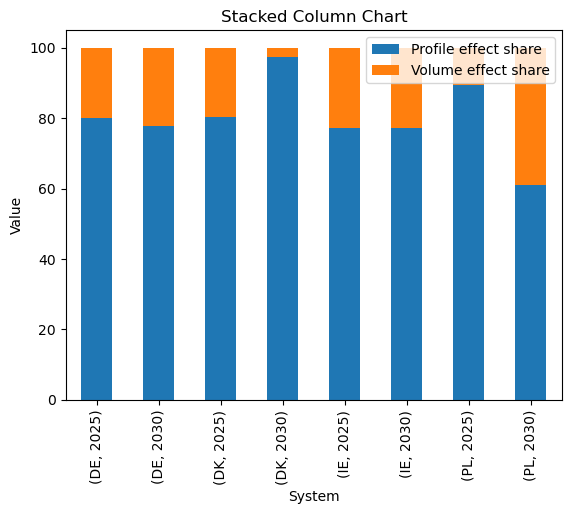

In [15]:
df = pd.DataFrame(fractions.sort_index())

# Create a stacked column chart
ax = df.plot(kind='bar', stacked=True)

# Customize the plot
ax.set_xlabel('System')
ax.set_ylabel('Value')
ax.set_title('Stacked Column Chart')

# Display the plot
plt.show()

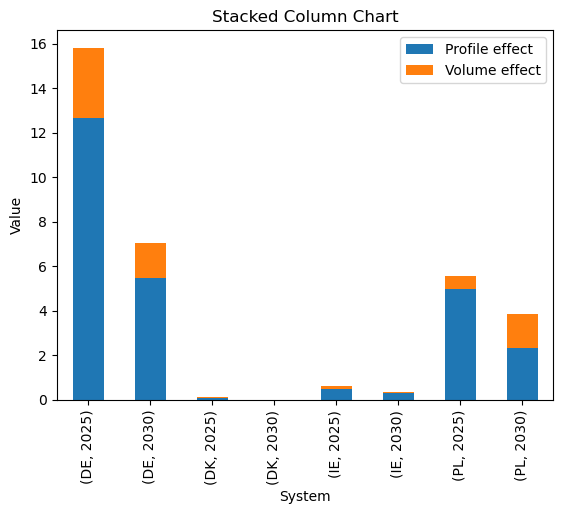

In [16]:
df = pd.DataFrame(abs.sort_index())

# Create a stacked column chart
ax = df.plot(kind='bar', stacked=True)

# Customize the plot
ax.set_xlabel('System')
ax.set_ylabel('Value')
ax.set_title('Stacked Column Chart')

# Display the plot
plt.show()

### Comparing emission reductions achieved by RES100% and 24/7 CFE 100%

In [17]:
data

,no procurement,100% 24/7 CFE,100% annual matching,Emissions reduction total,100% 24/7 CFE w/o excess,Profile effect,Volume effect
system,,,,,,,
"(IE, 2025)",4.168777,3.542470,3.689036,0.626307,3.693141,0.484187,0.142120
"(DK, 2025)",5.389010,5.278307,5.295009,0.110703,5.299968,0.089042,0.021661
"(DE, 2025)",118.810889,103.000312,107.080605,15.810577,106.186434,12.640678,3.169899
"(PL, 2025)",83.804790,78.226967,79.258311,5.577824,78.802011,4.991731,0.586093
"(IE, 2030)",2.478082,2.114343,2.279577,0.363740,2.211865,0.280522,0.083218
"(DK, 2030)",0.921909,0.914581,0.916650,0.007328,0.914430,0.007137,0.000191
"(DE, 2030)",50.380531,43.339646,47.396700,7.040885,44.903481,5.479131,1.561754
"(PL, 2030)",15.583535,11.752734,13.355023,3.830801,13.274702,2.334288,1.496514


In [18]:
# Compute decrease of local zone emissions achived 24/7 CFE *above* RES100% in % terms of no procurement case
df = pd.DataFrame()
df['Emissions_drop'] = (data['100% 24/7 CFE'] - data['100% annual matching'])/data['no procurement']*100
df

,Emissions_drop
system,
"(IE, 2025)",-3.515819
"(DK, 2025)",-0.309924
"(DE, 2025)",-3.434276
"(PL, 2025)",-1.230650
"(IE, 2030)",-6.667852
"(DK, 2030)",-0.224435
"(DE, 2030)",-8.052820
"(PL, 2030)",-10.281936


In [19]:
df.index = [f"{x[0]} {x[1]}" for x in df.index]

In [20]:
df.round(1)

,Emissions_drop
IE 2025,-3.5
DK 2025,-0.3
DE 2025,-3.4
PL 2025,-1.2
IE 2030,-6.7
DK 2030,-0.2
DE 2030,-8.1
PL 2030,-10.3


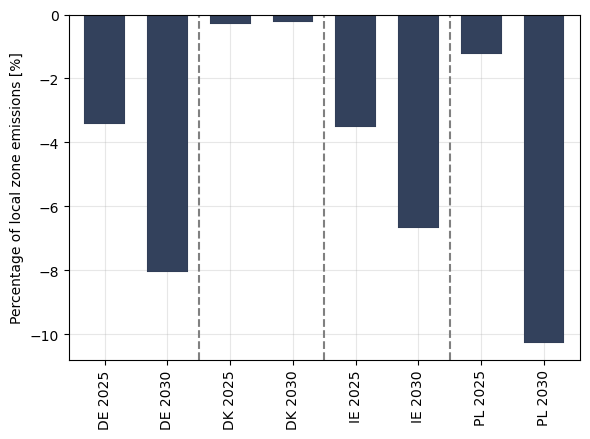

In [28]:
def plot_2():

    fig, ax = plt.subplots()
    fig.set_size_inches((6,4.5))

    ldf = df.sort_index()
    
    ldf.plot(kind="bar", ax=ax, 
        color='#33415c', width=0.65, edgecolor = "black", linewidth=0.05)
 
    plt.xticks(rotation=90)

    ax.grid(alpha=0.3)
    ax.set_axisbelow(True)
    ax.set_ylabel("Percentage of local zone emissions [%]")
    ax.get_legend().remove()
    plt.xlabel('')
    plt.axvline(x = 1.5, color = 'gray', linestyle="--")
    plt.axvline(x = 3.5, color = 'gray', linestyle="--")
    plt.axvline(x = 5.5, color = 'gray', linestyle="--")

    fig.tight_layout()
    fig.savefig("../results/paper/hourly-annual.pdf", transparent=True)

plot_2()

In [22]:
abs.index = [f"{x[0]} {x[1]}" for x in abs.index]

In [23]:
abs

,Profile effect,Volume effect
IE 2025,0.484187,0.142120
DK 2025,0.089042,0.021661
DE 2025,12.640678,3.169899
PL 2025,4.991731,0.586093
IE 2030,0.280522,0.083218
DK 2030,0.007137,0.000191
DE 2030,5.479131,1.561754
PL 2030,2.334288,1.496514


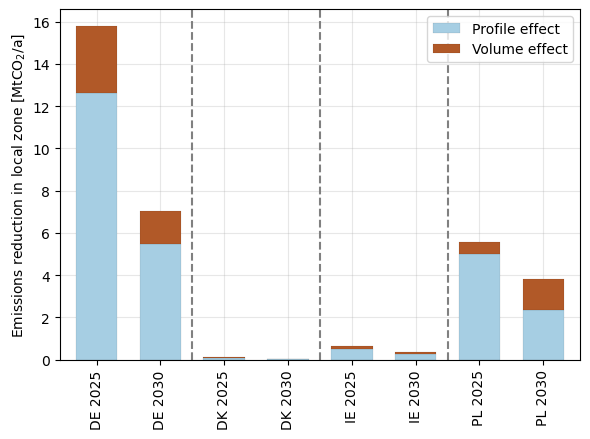

In [25]:
def plot_1():

    fig, ax = plt.subplots()
    fig.set_size_inches((6,4.5))

    typ = ["local","grid"]

    ldf = abs.sort_index()

    ldf.plot(kind="bar",stacked=True,
                ax=ax, 
                color=plt.cm.Paired(np.linspace(0, 1, len(ldf.columns))),
                width=0.65, edgecolor = "black", linewidth=0.05)

 
    plt.xticks(rotation=90)

    ax.grid(alpha=0.3)
    ax.set_axisbelow(True)
    ax.set_ylabel("Emissions reduction in local zone [MtCO$_2$/a]")
    plt.xlabel('')
    plt.axvline(x = 1.5, color = 'gray', linestyle="--")
    plt.axvline(x = 3.5, color = 'gray', linestyle="--")
    plt.axvline(x = 5.5, color = 'gray', linestyle="--")

    fig.tight_layout()
    fig.savefig("../results/paper/profile-volume.pdf", transparent=True)

plot_1()